In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
import zipfile

In [4]:
def unzip_folder(zip_path, dest_path):
    with zipfile.ZipFile(zip_path, "r") as zip_file:
        zip_file.extractall(dest_path)

In [5]:
zip_path = r"/Users/arnel/Downloads/Instacart Market Basket Analysis"
dest_path =r"/Users/arnel/Downloads/Instacart data"


In [6]:
# Begin looping through zipped folder 
for root, dirs, files in os.walk(zip_path):
    # Loop through files of zipped folders all at once 
    for file in files:
        if file.endswith(".zip"):
            # Create path that points directly to zipped file 
            full_file_path = os.path.join(root, file)
            # Run unzip_folder() using new full_file_path and destination
            unzip_folder(full_file_path, dest_path)

In [7]:
# Read the Instacart data into dataframes 
# Change directories to where unzipped Instacart data is located 
os.chdir(dest_path)

In [8]:
# List the files in my current working directory 
sourcefiles = os.listdir(dest_path)
sourcefiles

['products.csv',
 'orders.csv',
 '.DS_Store',
 'order_products__train.csv',
 'departments.csv',
 '__MACOSX',
 'aisles.csv',
 'order_products__prior.csv',
 'sample_submission.csv']

In [9]:
file_names = [os.path.splitext(file)[0] for file in sourcefiles if file.endswith(".csv")]

In [10]:
print(file_names)

['products', 'orders', 'order_products__train', 'departments', 'aisles', 'order_products__prior', 'sample_submission']


In [11]:
# dfs = {key: pd.read_csv(os.path.join(dest_path, file)) for key, file in zip(file_names, sourcefiles) if file.endswith(".csv")}
dfs = {file.stem: pd.read_csv(file.resolve()) for file in Path(dest_path).glob("*.csv")}

In [12]:
dfs.keys()

dict_keys(['products', 'orders', 'order_products__train', 'departments', 'aisles', 'order_products__prior', 'sample_submission'])

In [13]:
products_df = dfs["products"]
orders_df = dfs["orders"]
departments_df = dfs["departments"]
aisles_df = dfs["aisles"]
order_products_prior_df = dfs["order_products__prior"]

In [14]:
orders_df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

In [15]:
print(f'The dimension for the Dataframes are as follows:',
'\n''Products:',products_df.shape, 
'\n''Orders:', orders_df.shape,
'\n''Department:', departments_df.shape,
'\n''Aisles:', aisles_df.shape,
'\n''Prior Orders:', order_products_prior_df.shape)

The dimension for the Dataframes are as follows: 
Products: (49688, 4) 
Orders: (3421083, 7) 
Department: (21, 2) 
Aisles: (134, 2) 
Prior Orders: (32434489, 4)


In [16]:
# Merge the aisles dataframe with the products dataframe to create aisle_prodcut_merged 
# merged on 'order_id' using a 'inner' join
aisle_product_merged = pd.merge(aisles_df, products_df, on = 'aisle_id', how = 'inner')
aisle_product_merged

aisle_id                       aisle  product_id  \
0             1       prepared soups salads         209   
1             1       prepared soups salads         554   
2             1       prepared soups salads         886   
3             1       prepared soups salads        1600   
4             1       prepared soups salads        2539   
...         ...                         ...         ...   
49683       134  specialty wines champagnes       47713   
49684       134  specialty wines champagnes       48984   
49685       134  specialty wines champagnes       49438   
49686       134  specialty wines champagnes       49562   
49687       134  specialty wines champagnes       49661   

                                            product_name  department_id  
0                                    Italian Pasta Salad             20  
1                                           Turkey Chili             20  
2      Whole Grain Salad with Roasted Pecans & Mango ...             20  
3                               Mediterranean Orzo Salad             20  
4                                  Original Potato Salad             20  
...                                                  ...            ...  
49683                                     Sparkling Rose              5  
49684                                         Dry Sherry              5  
49685                                    Dry Fino Sherry              5  
49686                      Blanc De Noirs Sparkling Wine              5  
49687                                              Porto              5  

[49688 rows x 5 columns]

In [17]:
print(f'The shape of the new data frame', aisle_product_merged.shape)

The shape of the new data frame (49688, 5)


In [18]:
department_aisle_merged = pd.merge(aisle_product_merged, departments_df, on = "department_id", how = "inner")
department_aisle_merged

aisle_id                  aisle  product_id  \
0             1  prepared soups salads         209   
1             1  prepared soups salads         554   
2             1  prepared soups salads         886   
3             1  prepared soups salads        1600   
4             1  prepared soups salads        2539   
...         ...                    ...         ...   
49683       100                missing       49553   
49684       100                missing       49575   
49685       100                missing       49641   
49686       100                missing       49664   
49687       100                missing       49669   

                                            product_name  department_id  \
0                                    Italian Pasta Salad             20   
1                                           Turkey Chili             20   
2      Whole Grain Salad with Roasted Pecans & Mango ...             20   
3                               Mediterranean Orzo Salad             20   
4                                  Original Potato Salad             20   
...                                                  ...            ...   
49683                                 Organic Plain Skyr             21   
49684                     Chocolate Vanilla Malt Custard             21   
49685                                      8\" Pecan Pie             21   
49686                     Lemon Cayenne Drinking Vinegar             21   
49687                                   K Cup Dark Blend             21   

      department  
0           deli  
1           deli  
2           deli  
3           deli  
4           deli  
...          ...  
49683    missing  
49684    missing  
49685    missing  
49686    missing  
49687    missing  

[49688 rows x 6 columns]

In [19]:
print(f'The shape of the new data frame', department_aisle_merged.shape)

The shape of the new data frame (49688, 6)


In [20]:
products_df.columns

Index(['product_id', 'product_name', 'aisle_id', 'department_id'], dtype='object')

In [21]:
orders_df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

In [22]:
order_prior_merged = pd.merge(orders_df,order_products_prior_df, on = 'order_id', how = 'inner')
order_prior_merged.head(2)

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  
0                     NaN         196                  1          0  
1                     NaN       14084                  2          0

In [23]:
order_prod_prior_merged = pd.merge(products_df,order_prior_merged, on = 'product_id', how = 'inner') 
order_prod_prior_merged.head(2)


product_id                product_name  aisle_id  department_id  order_id  \
0           1  Chocolate Sandwich Cookies        61             19   3139998   
1           1  Chocolate Sandwich Cookies        61             19   1977647   

   user_id eval_set  order_number  order_dow  order_hour_of_day  \
0      138    prior            28          6                 11   
1      138    prior            30          6                 17   

   days_since_prior_order  add_to_cart_order  reordered  
0                     3.0                  5          0  
1                    20.0                  1          1

In [24]:
order_prod_prior_merged.shape

(32434489, 13)

In [25]:
order_prod_prior_merged_1 = pd.merge(orders_df,order_products_prior_df, on = 'order_id', how = 'left')
order_prod_prior_merged_2 = pd.merge(products_df,order_prod_prior_merged_1, on = 'product_id', how = 'left') 
order_prod_prior_merged_2.head(2)

product_id                product_name  aisle_id  department_id   order_id  \
0           1  Chocolate Sandwich Cookies        61             19  3139998.0   
1           1  Chocolate Sandwich Cookies        61             19  1977647.0   

   user_id eval_set  order_number  order_dow  order_hour_of_day  \
0    138.0    prior          28.0        6.0               11.0   
1    138.0    prior          30.0        6.0               17.0   

   days_since_prior_order  add_to_cart_order  reordered  
0                     3.0                5.0        0.0  
1                    20.0                1.0        1.0

In [26]:
print(order_prod_prior_merged.describe())

         product_id      aisle_id  department_id      order_id       user_id  \
count  3.243449e+07  3.243449e+07   3.243449e+07  3.243449e+07  3.243449e+07   
mean   2.557634e+04  7.121430e+01   9.921906e+00  1.710749e+06  1.029372e+05   
std    1.409669e+04  3.820302e+01   6.281156e+00  9.873007e+05  5.946648e+04   
min    1.000000e+00  1.000000e+00   1.000000e+00  2.000000e+00  1.000000e+00   
25%    1.353000e+04  3.100000e+01   4.000000e+00  8.559430e+05  5.142100e+04   
50%    2.525600e+04  8.300000e+01   9.000000e+00  1.711048e+06  1.026110e+05   
75%    3.793500e+04  1.070000e+02   1.600000e+01  2.565514e+06  1.543910e+05   
max    4.968800e+04  1.340000e+02   2.100000e+01  3.421083e+06  2.062090e+05   

       order_number     order_dow  order_hour_of_day  days_since_prior_order  \
count  3.243449e+07  3.243449e+07       3.243449e+07            3.035642e+07   
mean   1.714205e+01  2.738818e+00       1.342498e+01            1.110407e+01   
std    1.753504e+01  2.090049e+00      

In [27]:
print(order_prod_prior_merged_2.describe())

         product_id      aisle_id  department_id      order_id       user_id  \
count  3.243450e+07  3.243450e+07   3.243450e+07  3.243449e+07  3.243449e+07   
mean   2.557634e+04  7.121430e+01   9.921908e+00  1.710749e+06  1.029372e+05   
std    1.409669e+04  3.820302e+01   6.281156e+00  9.873007e+05  5.946648e+04   
min    1.000000e+00  1.000000e+00   1.000000e+00  2.000000e+00  1.000000e+00   
25%    1.353000e+04  3.100000e+01   4.000000e+00  8.559430e+05  5.142100e+04   
50%    2.525600e+04  8.300000e+01   9.000000e+00  1.711048e+06  1.026110e+05   
75%    3.793500e+04  1.070000e+02   1.600000e+01  2.565514e+06  1.543910e+05   
max    4.968800e+04  1.340000e+02   2.100000e+01  3.421083e+06  2.062090e+05   

       order_number     order_dow  order_hour_of_day  days_since_prior_order  \
count  3.243449e+07  3.243449e+07       3.243449e+07            3.035642e+07   
mean   1.714205e+01  2.738818e+00       1.342498e+01            1.110407e+01   
std    1.753504e+01  2.090049e+00      

In [28]:
# Group by 'product_name' and calculate the count of each product
most_ordered = order_prod_prior_merged_2.groupby("product_name").agg(count_items=pd.NamedAgg(column="product_name", aggfunc="count"))

# Sort the result in ascending order by 'count_items'
most_ordered_ascending = most_ordered.sort_values(by="count_items", ascending=False)

# Optionally, if you want only the top 10 items in ascending order
most_ordered_10_ascending = most_ordered_ascending.head(10)

# Display the result
print(most_ordered_10_ascending)

                        count_items
product_name                       
Banana                       472565
Bag of Organic Bananas       379450
Organic Strawberries         264683
Organic Baby Spinach         241921
Organic Hass Avocado         213584
Organic Avocado              176815
Large Lemon                  152657
Strawberries                 142951
Limes                        140627
Organic Whole Milk           137905


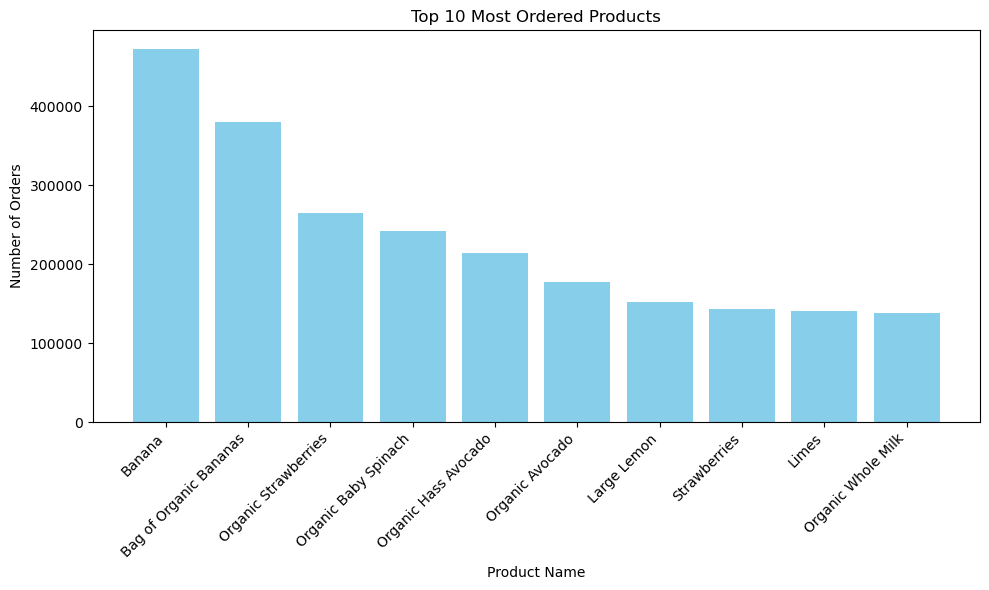

In [29]:
import matplotlib.pyplot as plt

# Plotting the bar chart
plt.figure(figsize=(10, 6))  # Optional: sets the size of the plot
plt.bar(most_ordered_10_ascending.index, most_ordered_10_ascending['count_items'], color='skyblue')

# Adding labels and title
plt.xlabel('Product Name')
plt.ylabel('Number of Orders')
plt.title('Top 10 Most Ordered Products')

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

Customers tend to order alot of organic produce which would have me to assume that they are health conscious individuals

In [30]:
# Group by 'product_name' and calculate the count of each product
most_reordered = order_prod_prior_merged_2.groupby(["reordered", "product_name"]).agg(count_items=pd.NamedAgg(column="product_name", aggfunc="count"))

# Sort the result in ascending order by 'count_items'
most_reordered_ascending = most_reordered.sort_values(by="count_items", ascending=False)

# Optionally, if you want only the top 10 items in ascending order
most_reordered_10_ascending = most_reordered_ascending.head(10)

# Display the result
print(most_reordered_10_ascending)

                                  count_items
reordered product_name                       
1.0       Banana                       398609
          Bag of Organic Bananas       315913
          Organic Strawberries         205845
          Organic Baby Spinach         186884
          Organic Hass Avocado         170131
          Organic Avocado              134044
          Organic Whole Milk           114510
          Large Lemon                  106255
          Organic Raspberries          105409
          Strawberries                  99802


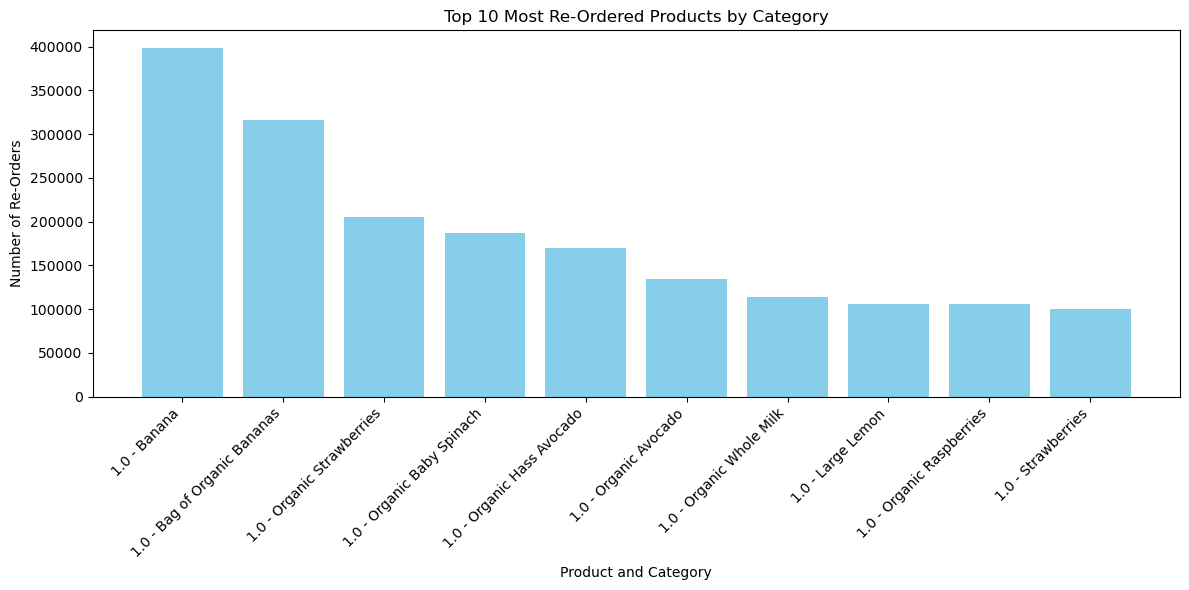

In [31]:
import matplotlib.pyplot as plt

# Assuming `most_ordered_10_ascending` is the DataFrame you already computed
# Flatten the multi-index (product_name and category_name)
most_reordered_10_ascending['product_name'] = most_reordered_10_ascending.index.map(lambda x: f"{x[0]} - {x[1]}")

# Plotting the bar chart
plt.figure(figsize=(12, 6))  # Set figure size
plt.bar(most_reordered_10_ascending['product_name'], most_reordered_10_ascending['count_items'], color='skyblue')

# Adding labels and title
plt.xlabel('Product and Category')
plt.ylabel('Number of Re-Orders')
plt.title('Top 10 Most Re-Ordered Products by Category')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Adjust the layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()


In addition to ordering mostly organic produce, given that the shelf life for these items arent as stable as can goods, it means that they consume that at a higher rate in order to avoid waste.

In [32]:
popular_dept = department_aisle_merged.groupby( "department").agg(count_items=pd.NamedAgg(column="department", aggfunc="count"))

# Sort the result in ascending order by 'count_items'
popular_dept_ascending = popular_dept.sort_values(by="count_items", ascending=False)

# Optionally, if you want only the top 20 items in ascending order
most_popular_dept_20_ascending = popular_dept_ascending.head(20)

# Display the result
print(most_popular_dept_20_ascending)

                 count_items
department                  
personal care           6563
snacks                  6264
pantry                  5371
beverages               4365
frozen                  4007
dairy eggs              3449
household               3085
canned goods            2092
dry goods pasta         1858
produce                 1684
bakery                  1516
deli                    1322
missing                 1258
international           1139
breakfast               1115
babies                  1081
alcohol                 1054
pets                     972
meat seafood             907
other                    548


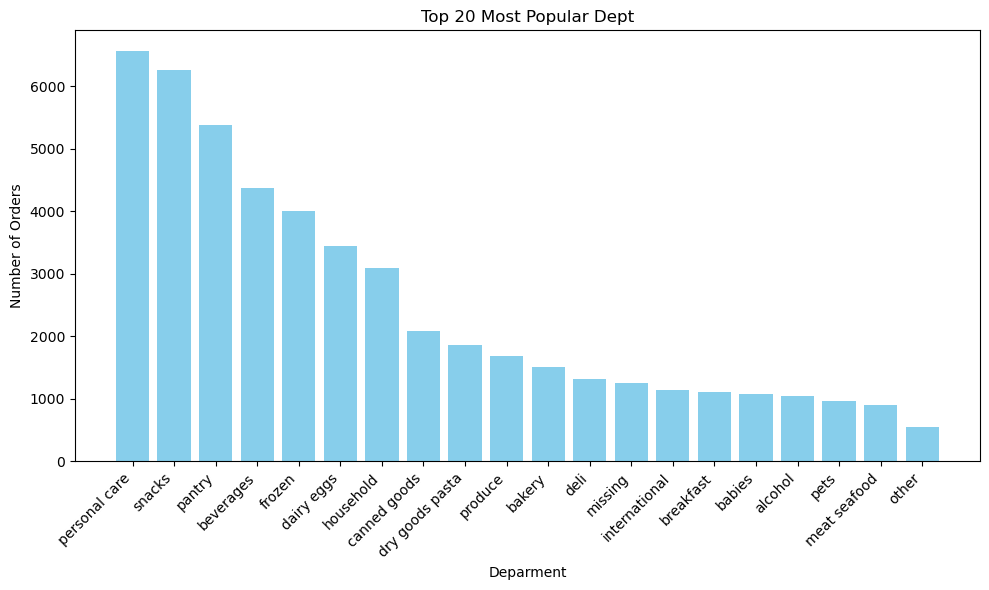

In [33]:

# Plotting the bar chart
plt.figure(figsize=(10, 6))  # Optional: sets the size of the plot
plt.bar(most_popular_dept_20_ascending.index, most_popular_dept_20_ascending['count_items'], color='skyblue')

# Adding labels and title
plt.xlabel('Deparment')
plt.ylabel('Number of Orders')
plt.title('Top 20 Most Popular Dept')

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


The most popular department is personal care followed by snacks

In [34]:
dow_mapping = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Replace the 'dow' column with the corresponding day names
order_prod_prior_merged_2['day_of_week'] = order_prod_prior_merged_2['order_dow'].map(dow_mapping)

# Group by 'day_of_week' and calculate the number of orders for each day
orders_by_day = order_prod_prior_merged_2.groupby('day_of_week').size().reset_index(name='num_orders')


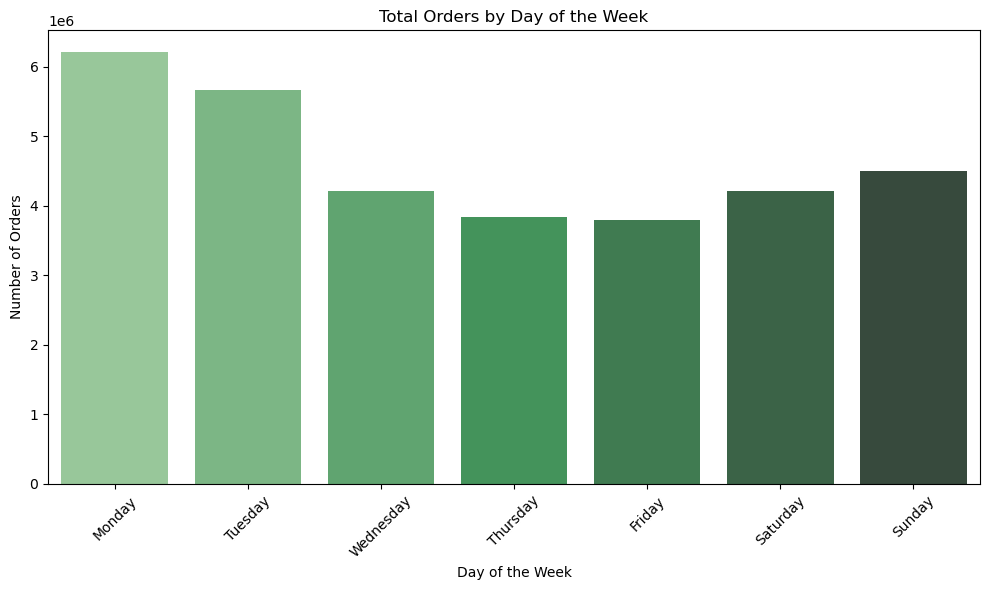

In [35]:
# Reorder the 'day_of_week' column to ensure it is in ascending order (Mon-Sun)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
orders_by_day['day_of_week'] = pd.Categorical(orders_by_day['day_of_week'], categories=days_order, ordered=True)

# Sort the DataFrame by day of the week
orders_by_day_sorted = orders_by_day.sort_values('day_of_week', ascending = False)

# Plotting the bar chart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='num_orders', data=orders_by_day_sorted, palette='Greens_d')

# Adding labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.title('Total Orders by Day of the Week')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

Based on the Mondays looks like it is the day with the most orders place

In [36]:
busiest_hour = order_prod_prior_merged_2.groupby("order_hour_of_day").agg(count_items=pd.NamedAgg(column="order_hour_of_day", aggfunc="count"))

# Sort the result in ascending order by 'count_items'
busiest_hour_ascending = busiest_hour.sort_values(by="count_items", ascending=False)

# only the top 5 order hour of the day in ascending order
busiest_hour_5_ascending = busiest_hour_ascending.head(5)

# Display the result
print(busiest_hour_5_ascending)

                   count_items
order_hour_of_day             
10.0                   2764426
11.0                   2738582
14.0                   2691548
15.0                   2664533
13.0                   2663292


In [37]:
prob = np.round((2764426/sum(busiest_hour_5_ascending.count_items)),4)*100
prob

20.44

 The hour of the day  that customers most likely would order a product is 10 AM with a probability of 20%

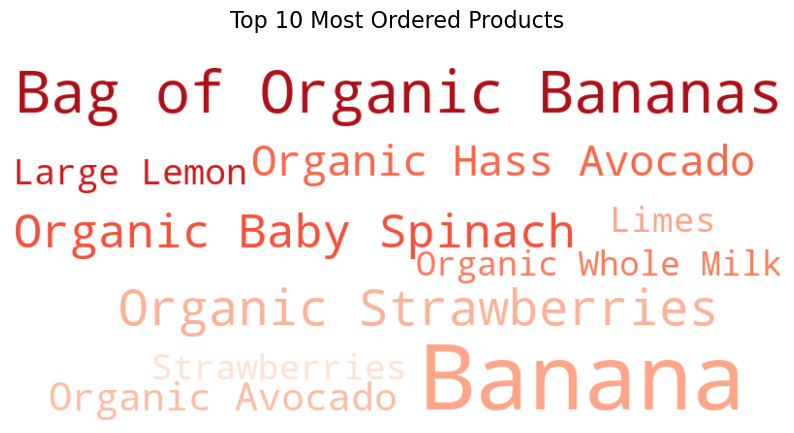

In [38]:

from wordcloud import WordCloud



# StConvert the DataFrame to a dictionary where product names are the keys and counts are the values
product_counts = most_ordered_10_ascending['count_items'].to_dict()
product_names = most_ordered_10_ascending.index

# Create a WordCloud instance and generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      colormap='Reds').generate_from_frequencies(product_counts)

# Plot the Word Cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Top 10 Most Ordered Products', fontsize=16)
plt.show()



Bananas followed by avocado  in general are  the most ordered items  from the data.

In [39]:
# Group by 'order_dow' (day of the week) and 'order_hour_of_day' (hour of the day) to get the frequency of orders
order_counts = order_prod_prior_merged_2.groupby(['order_dow', 'order_hour_of_day']).size().reset_index(name='order_count')

# Pivot the table so we can create a heatmap
order_pivot = order_counts.pivot('order_dow', 'order_hour_of_day', 'order_count')

# Set the index to be more readable by mapping dow (0-6) to day names
dow_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
order_pivot.index = order_pivot.index.map(dow_mapping)

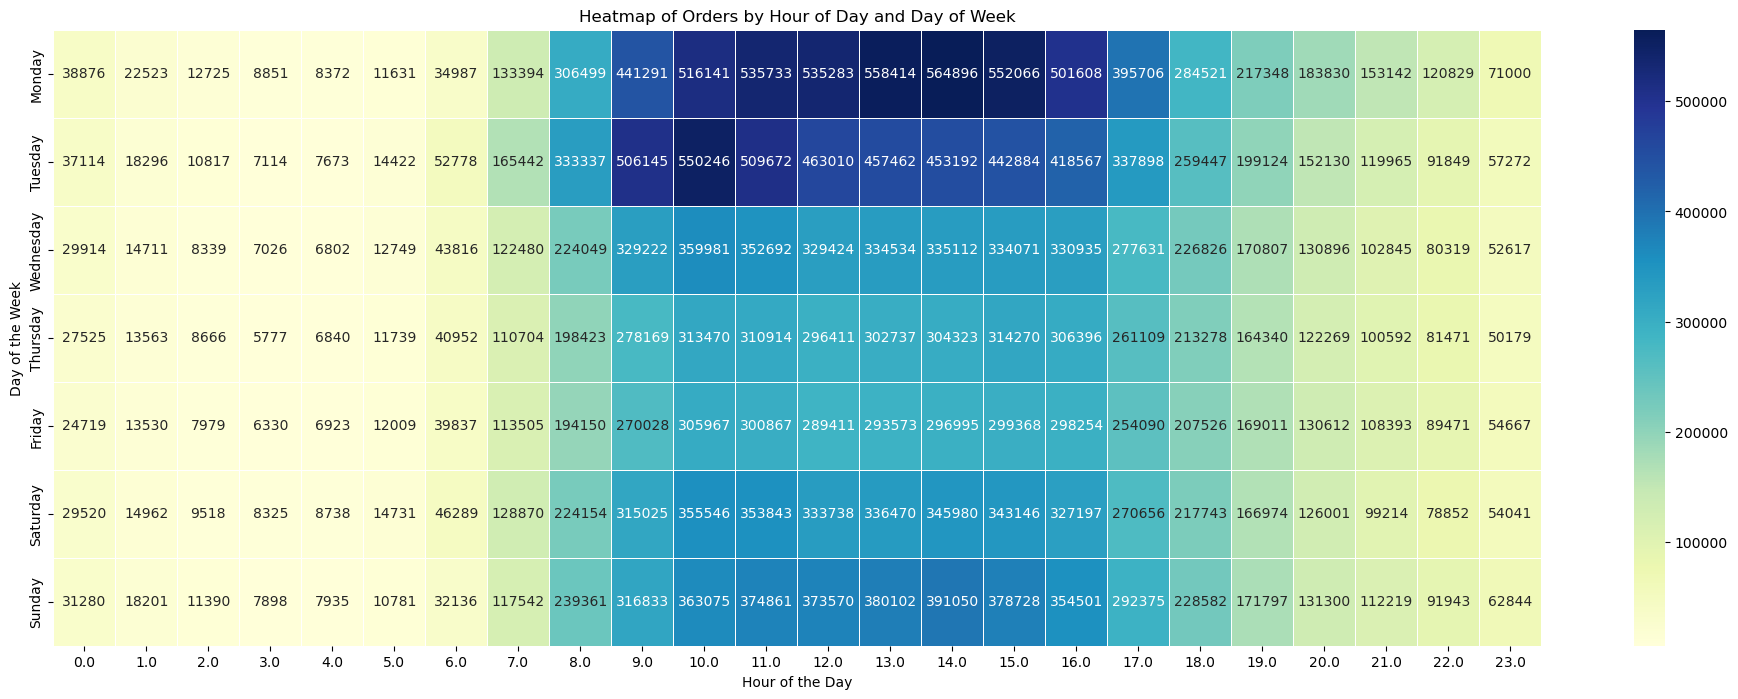

In [54]:
# Plot the heatmap using seaborn
plt.figure(figsize=(24, 8))
sns.heatmap(order_pivot, annot=True, fmt='g', cmap='YlGnBu', linewidths=.5)

# Adding labels and title
plt.title('Heatmap of Orders by Hour of Day and Day of Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')

# Show the plot
plt.show()

The peak shopping hours would be between 8am - 6pm All week with Monday and Tuesday being the most busiest days

In [88]:


# Group by 'product_id' or 'department_id', and calculate the reorder probability
# Here, we're grouping by 'product_id' and calculating the mean of 'reordered' (0 or 1) to get the reorder probability
reorder_prob = order_prod_prior_merged_2.groupby('product_id')['reordered'].mean().reset_index(name='reorder_probability')

# Optionally, if you want to calculate the reorder probability by department, use 'department_id' instead
#reorder_prob = order_prod_prior_merged_2.groupby('department_id')['reordered'].mean().reset_index(name='reorder_probability')

# Sorting the result based on reorder probability (optional)
reorder_prob_sorted = reorder_prob.sort_values(by='reorder_probability', ascending=False)


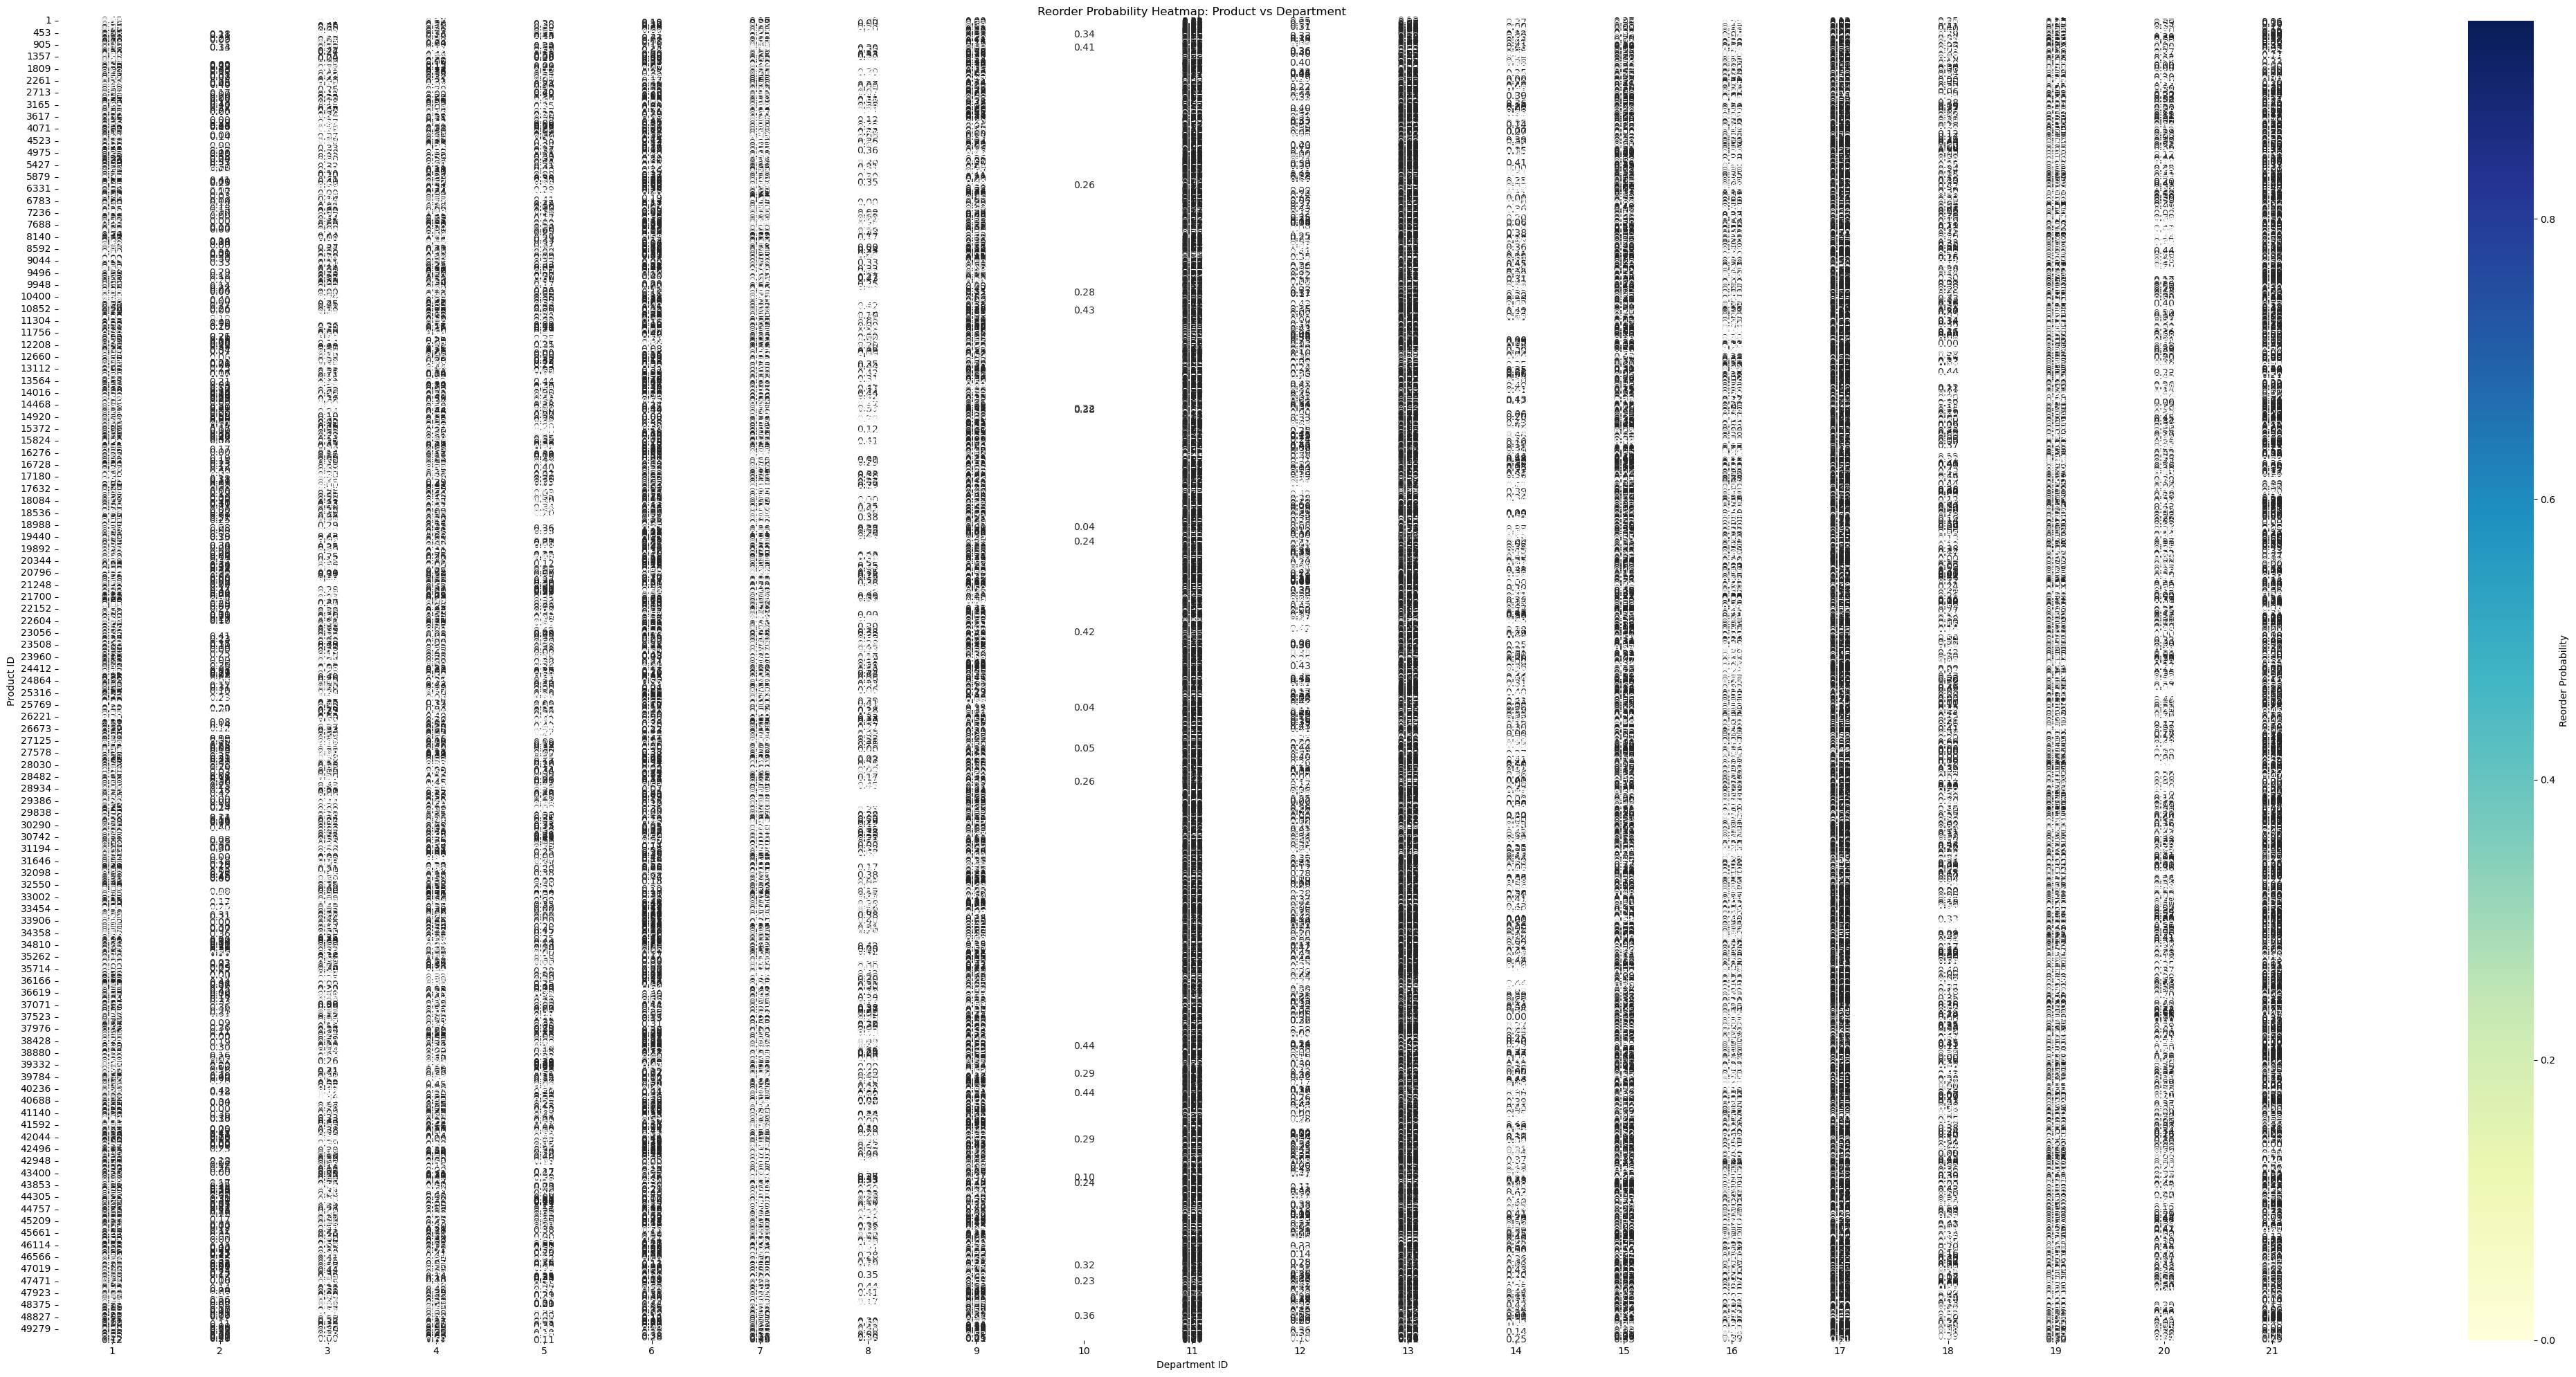

In [89]:
# Create a heatmap using seaborn
plt.figure(figsize=(42, 20))
sns.heatmap(reorder_matrix, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'Reorder Probability'}, linewidths=0.5)

# Add labels and title
plt.title('Reorder Probability Heatmap: Product vs Department')
plt.xlabel('Department ID')
plt.ylabel('Product ID')

# Show the plot
plt.tight_layout()
plt.show()

In [87]:
# Group by product or department and calculate the counts of reordered vs. new orders
product_reorder_counts = order_prod_prior_merged_2.groupby(['product_name', 'reordered']).size().unstack(fill_value=0)

# Add a column for the total count of orders per product or department
product_reorder_counts['total_orders'] = product_reorder_counts.sum(axis=1)

# Calculate the proportion of reordered vs. new products
product_reorder_counts['reorder_proportion'] = product_reorder_counts[1] / product_reorder_counts['total_orders']
product_reorder_counts['new_proportion'] = product_reorder_counts[0] / product_reorder_counts['total_orders']

# Sort by reorder proportion if needed
product_reorder_counts = product_reorder_counts.sort_values(by='reorder_proportion', ascending=False)

# Display the proportions
print(product_reorder_counts[['reorder_proportion', 'new_proportion']].head(20))

reordered                                 reorder_proportion  new_proportion
product_name                                                                
Raw Veggie Wrappers                                 0.941176        0.058824
Serenity Ultimate Extrema Overnight Pads            0.931034        0.068966
Orange Energy Shots                                 0.923077        0.076923
Chocolate Love Bar                                  0.920792        0.079208
Soy Powder Infant Formula                           0.914286        0.085714
Simply Sleep Nighttime Sleep Aid                    0.911111        0.088889
Energy Shot, Grape Flavor                           0.909091        0.090909
Russian River Valley Reserve Pinot Noir             0.900000        0.100000
Maca Buttercups                                     0.900000        0.100000
Sparking Water                                      0.900000        0.100000
Bars Peanut Butter                                  0.895522        0.104478

The trend I observe is that theres a greater chance of something being reorderd than being ordered for the first time

In [45]:
# Calculate the order size for each order (i.e., number of items in each order)
order_sizes = order_prod_prior_merged_2.groupby('order_id').size().reset_index(name='order_size')

# Merge this order size back with the customer data (if necessary)
customer_order_sizes = pd.merge(order_sizes, orders_df[['order_id', 'user_id']], on='order_id', how='left')

customer_order_sizes.head(5)

order_id  order_size  user_id
0       2.0           9   202279
1       3.0           8   205970
2       4.0          13   178520
3       5.0          26   156122
4       6.0           3    22352

 Now 'customer_order_sizes' contains the order size for each order along with the corresponding user_id

In [51]:
# # Plotting the distribution of order sizes using seaborn

# plt.figure(figsize=(10, 6))

# # Plot histogram with KDE for order sizes by customer
# sns.histplot(data=customer_order_sizes, y='order_size', hue='user_id', kde=True, 
#              bins=30, palette='Set2', alpha=0.6)

# # Adding labels and title
# plt.title('Distribution of Order Sizes by Customer', fontsize=16)
# plt.ylabel('Order Size (Number of Items per Order)', fontsize=12)
# plt.xlabel('Frequency', fontsize=12)

# # Show the plot
# plt.tight_layout()
# plt.show()

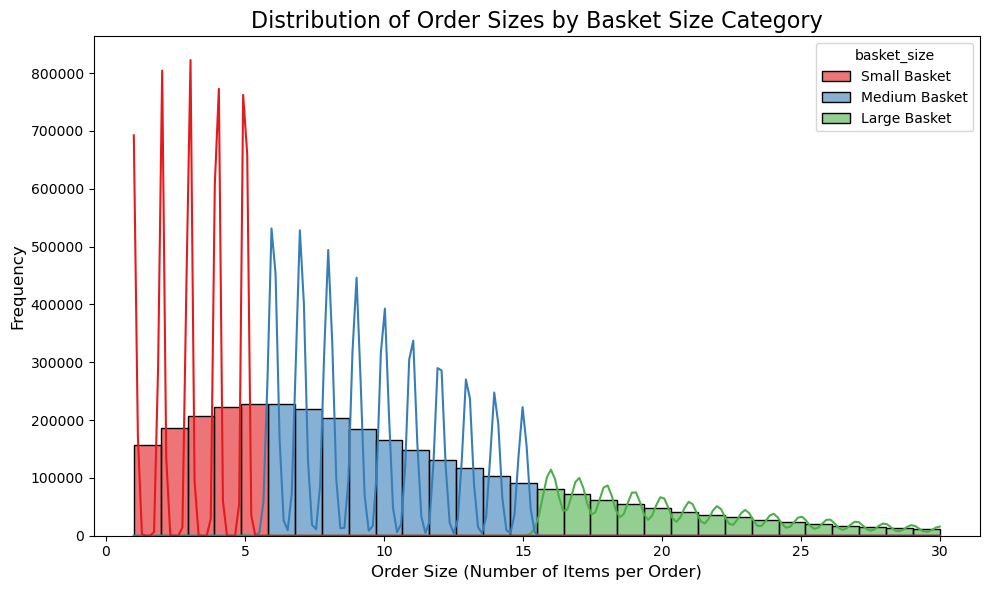

In [50]:
# Define order size bins (e.g., small, medium, large)
bins = [0, 5, 15, 30]
labels = ['Small Basket', 'Medium Basket', 'Large Basket']

# Segment customers based on their average order size
customer_order_sizes['basket_size'] = pd.cut(customer_order_sizes['order_size'], bins=bins, labels=labels)

# Plot histogram or KDE by basket size
plt.figure(figsize=(10, 6))
sns.histplot(data=customer_order_sizes, x='order_size', hue='basket_size', kde=True, 
             bins=30, palette='Set1', alpha=0.6)

# Add labels and title
plt.title('Distribution of Order Sizes by Basket Size Category', fontsize=16)
plt.xlabel('Order Size (Number of Items per Order)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

The majority of customers based on their basket sizes would order less than 15 items

In [57]:
# Group by customer_id and calculate the number of reorders and total orders for each customer
customer_reorder_counts = order_prod_prior_merged_2.groupby('user_id')['reordered'].value_counts().unstack(fill_value=0)

# Calculate the percentage of reorders for each customer
customer_reorder_counts['reorder_percentage'] = (customer_reorder_counts[1] / (customer_reorder_counts[0] + customer_reorder_counts[1])) * 100

# Optionally, sort by reorder percentage
customer_reorder_counts_sorted = customer_reorder_counts.sort_values(by='reorder_percentage', ascending=False)

# Display the reorder percentage for the first few customers
print(customer_reorder_counts_sorted[['reorder_percentage']].head(5) )

reordered  reorder_percentage
user_id                      
99753.0             98.952880
82414.0             98.130841
107528.0            98.076923
17997.0             97.931034
5588.0              97.885740


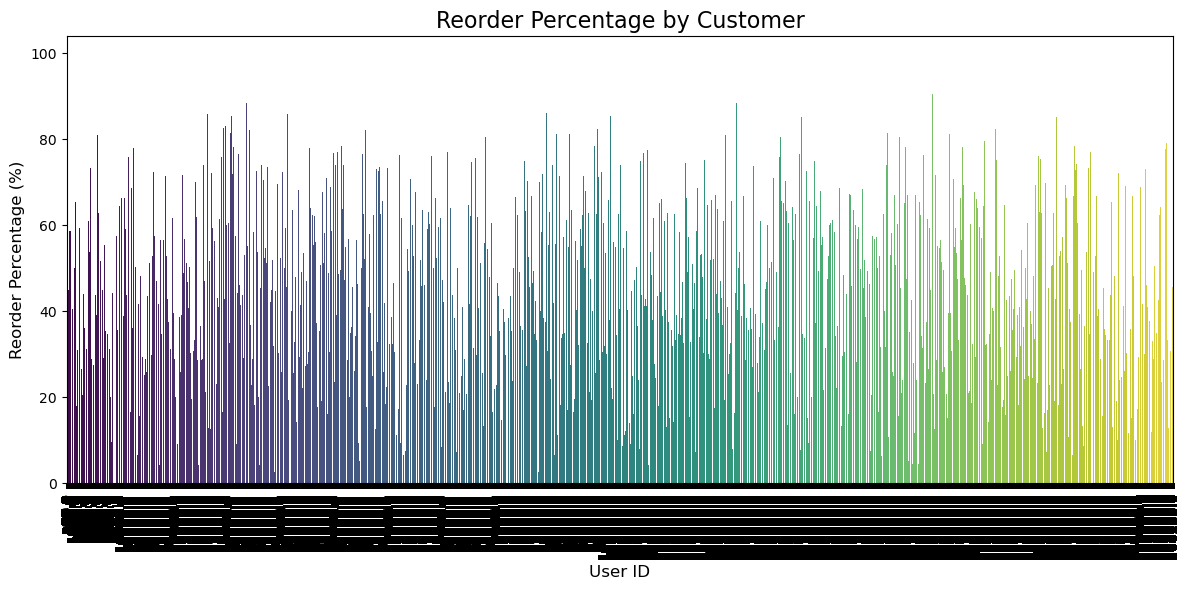

In [55]:
# Plotting a bar chart for the reorder percentage by customer
plt.figure(figsize=(12, 6))

# Create a bar plot showing the reorder percentage for each customer
sns.barplot(x=customer_reorder_counts_sorted.index, y=customer_reorder_counts_sorted['reorder_percentage'], palette='viridis')

# Add labels and title
plt.title('Reorder Percentage by Customer', fontsize=16)
plt.xlabel('User ID', fontsize=12)
plt.ylabel('Reorder Percentage (%)', fontsize=12)

# Rotate x-axis labels if necessary
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

In [68]:

customer_reorder_counts_sorted.reorder_percentage.describe()

count    206209.000000
mean         43.224927
std          21.214404
min           0.000000
25%          26.785714
50%          42.857143
75%          59.574468
max          98.952880
Name: reorder_percentage, dtype: float64

The average customer is 43% most likely to reorder, so I would say that the customer base is somewhat loyal